# Wasserstein distance estimation

In [54]:
import sys
sys.path.append("/home/lauro/code/msc-thesis/svgd")
sys.path.append("/home/lauro/code/msc-thesis/wassdistance")

import jax
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
from jax.experimental import optimizers

import matplotlib.pyplot as plt
import numpy as onp
from tqdm import tqdm
import time
from functools import partial

import utils
import metrics
import plot
from svgd import SVGD
import svgd
import stein
import kernels
import train

rkey = random.PRNGKey(0)

from jax.config import config; config.update("jax_log_compiles", 1)

# Torch Wasserstein distance

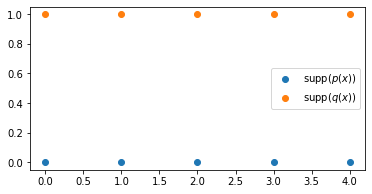

In [55]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

n_points = 5
a = np.array([[i, 0] for i in range(n_points)])
b = np.array([[i, 1] for i in range(n_points)])

plt.figure(figsize=(6, 3))
plt.scatter(a[:, 0], a[:, 1], label='supp($p(x)$)')
plt.scatter(b[:, 0], b[:, 1], label='supp($q(x)$)')
plt.legend();

In [56]:
import torch
from layers import SinkhornDistance

x = torch.tensor(a, dtype=torch.float)
y = torch.tensor(b, dtype=torch.float)

sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction=None)
dist, P, C = sinkhorn(x, y)
print("Sinkhorn distance: {:.3f}".format(dist.item()))

Sinkhorn distance: 1.000


In [58]:
print(x.shape)

torch.Size([5, 2])


Try same thing with other arrays:

In [59]:
d1 = metrics.Gaussian(0, 1)
d2 = metrics.Gaussian(1, 1)

n = 1000
y1 = d1.sample(n)
y2 = d1.sample(n)

In [60]:
ty1 = torch.from_numpy(onp.asarray(y1))
ty2 = torch.from_numpy(onp.asarray(y2))

In [61]:
ty1.shape

torch.Size([1000, 1])

In [53]:
sinkhorn(ty1, ty2)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got -3)

# Wasserstein distance in $n$ dimensions

Implementation idea from here: https://stackoverflow.com/questions/57562613/python-earth-mover-distance-of-2d-arrays

In [30]:
d1 = metrics.Gaussian(0, 1)
d2 = metrics.Gaussian(1, 1)

n = 1000
y1 = d1.sample(n)
y2 = d1.sample(n)

from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

d = cdist(y1, y2)
assignment = linear_sum_assignment(d)
print(d[assignment].sum() / n)

0.06973329145309981


In [31]:
from scipy.stats import wasserstein_distance

y1, y2 = [np.squeeze(y) for y in (y1, y2)]
wasserstein_distance(y1, y2)

0.06973329145309982

## Analytical Wasserstein distance between two gaussians

Let $\mu_{1}=\mathcal{N}\left(m_{1}, C_{1}\right)$ and $\mu_{2}=\mathcal{N}\left(m_{2}, C_{2}\right)$ be two non-degenerate Gaussian measures (i.e. normal distributions) on $\mathbb{R}^{n},$ with respective expected values $m_{1}$ and $m_{2} \in \mathbb{R}^{n}$ and symmetric positive semi-definite covariance matrices $C_{1}$ and $C_{2} \in \mathbb{R}^{n \times n} .$ Then, with respect to the usual Euclidean norm on $\mathbb{R}^{n},$ the 2
Wasserstein distance between $\mu_{1}$ and $\mu_{2}$ is

$$W_{2}\left(\mu_{1}, \mu_{2}\right)^{2}=\left\|m_{1}-m_{2}\right\|_{2}^{2}+\operatorname{trace}\left(C_{1}+C_{2}-2\left(C_{2}^{1 / 2} C_{1} C_{2}^{1 / 2}\right)^{1 / 2}\right)$$

## Wasserstein distance between two discrete distributions

See the scipy implementation [here](https://github.com/scipy/scipy/blob/adc4f4f7bab120ccfab9383aba272954a0a12fb0/scipy/stats/stats.py#L7094).

In [3]:
from stats import wasserstein_distance

In [26]:
a = [0, 1, 3]
b = [5, 6, 8]
wasserstein_distance(a, b)

5.0

## Wasserstein distance between sample and density